In [1]:
import pandas as pd
import numpy as np
import gc
import os
import json
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.neighbors import NearestNeighbors
import open3d as o3d
import copy
import transforms3d

In [2]:
%matplotlib notebook

In [3]:
BASE_PATH = "/home/sabyasachi/Projects/ati/data/data/datasets/Carla/64beam-Data"
LIDAR_RANGE = 120
USE_EXTENT = True


DYNAMIC_FOLDER = "dynamic"
NONPLAYERS_FOLDER = "_nonplayers"
PCD_FOLDER = "_out"
ANNOT_FILE = "annotation.csv"

GROUNDTRUTH_FILE = "groundTruth.csv"
PCD_IDX_COLUMN = 'step'

DYNAMIC_PATH = os.path.join(BASE_PATH, DYNAMIC_FOLDER)

In [4]:
NONPLAYER_AGENT_STR = "non_player_agents"
dynamic_non_player_type_list = ["vehicle", "pedestrian"]


In [5]:
def parse_clean_list(clean_str_list):
    location_str = "location"
    orientation_str = "orientation"
    rotation_str = "rotation"
    bounding_box_str = "bounding_box"
    extent_str = "extent"

    x_str = "x"
    y_str = "y"
    z_str = "z"
    yaw_str = "yaw"

    non_player_dict = {}
    non_player_dict["id"] = clean_str_list[1]
    non_player_dict["type"] = clean_str_list[2]

    # Extract all list indices
    location_idx = clean_str_list.index(location_str)
    orientation_idx = clean_str_list.index(orientation_str)
    rotation_idx = clean_str_list.index(rotation_str)
    bounding_box_idx = clean_str_list.index(bounding_box_str)
    extent_idx = clean_str_list.index(extent_str)

    # Get relevant list subsets
    location_str_list = clean_str_list[location_idx:orientation_idx]
    rotation_str_list = clean_str_list[rotation_idx:bounding_box_idx]
    extent_str_list = clean_str_list[extent_idx:]

    # Extract location: x,y,z
    non_player_dict["location_x"] = float(location_str_list[location_str_list.index(x_str)+1])
    non_player_dict["location_y"] = float(location_str_list[location_str_list.index(y_str)+1])
    non_player_dict["location_z"] = float(location_str_list[location_str_list.index(z_str)+1])

    # Extract heading rotation: yaw
    non_player_dict["yaw"] = float(rotation_str_list[rotation_str_list.index(yaw_str)+1])

    # Extract bounding box extent: x,y,z
    non_player_dict["extent_x"] = float(extent_str_list[extent_str_list.index(x_str)+1])
    non_player_dict["extent_y"] = float(extent_str_list[extent_str_list.index(y_str)+1])
    non_player_dict["extent_z"] = float(extent_str_list[extent_str_list.index(z_str)+1])
    
    # Get min, max extent in xy plane
    min_extent = min(non_player_dict["extent_x"], non_player_dict["extent_y"])
    max_extent = max(non_player_dict["extent_x"], non_player_dict["extent_y"])
    non_player_dict["min_extent"] = min_extent
    non_player_dict["max_extent"] = max_extent
    
    return non_player_dict

def get_relative_yaw(theta1, theta2):
    rel_yaw = theta2 - theta1
    if rel_yaw > 180:
        actual_rel_yaw = rel_yaw - 360
    elif rel_yaw <= -180:
        actual_rel_yaw = rel_yaw + 360
    else:
        actual_rel_yaw = rel_yaw
    return actual_rel_yaw

def pose2matrix(translation_list, rotation_angle_list):
    trans_vec = np.array(translation_list)
    rot_ang = [np.deg2rad(ang) for ang in rotation_angle_list ]
    rot_mat = transforms3d.euler.euler2mat(rot_ang[0], rot_ang[1], rot_ang[2])
    zoom = np.ones(3)
    transform_mat = transforms3d.affines.compose(trans_vec, rot_mat, zoom)
    return transform_mat

In [6]:
# sub_folder = "17"
for sub_folder in os.listdir(DYNAMIC_PATH):
    GROUNDTRUTH_PATH = os.path.join(DYNAMIC_PATH, sub_folder, GROUNDTRUTH_FILE)
    if os.path.exists(GROUNDTRUTH_PATH):
        df_gt = pd.read_csv(GROUNDTRUTH_PATH)
    else:
        print("Error: Could not find ground truth csv at path : {}".format(GROUNDTRUTH_PATH))
    #     continue

    NONPLAYERS_PATH = os.path.join(DYNAMIC_PATH, sub_folder, NONPLAYERS_FOLDER)
    if os.path.exists(NONPLAYERS_PATH):
        json_file_idx_list = sorted([int(file[:-5]) for file in os.listdir(NONPLAYERS_PATH)])
    else:
        print("Error: Could not find ground truth csv at path : {}".format(NONPLAYERS_PATH))
    #     continue


    df_gt=df_gt[df_gt[PCD_IDX_COLUMN].isin(json_file_idx_list)]
    # PCD_PATH = os.path.join(DYNAMIC_PATH, sub_folder, PCD_FOLDER)

    annotation_list = []
    for gt_idx, gt_row in tqdm_notebook(df_gt.iterrows(), total=df_gt.shape[0]):
        # Read faking json file
        json_file_name = str(int(gt_row[PCD_IDX_COLUMN])) + ".json"
        json_file_path = os.path.join(NONPLAYERS_PATH, json_file_name)

        with open(json_file_path, "r") as json_file_data:
            json_file_str = json_file_data.read()

        # Parse the faking json file
        non_player_str_list = re.split(NONPLAYER_AGENT_STR, json_file_str)
        non_player_str_list

        dynamic_str_list = [non_player_str for non_player_str in non_player_str_list[1:]\
                                            for non_player_type in dynamic_non_player_type_list\
                                              if non_player_type in non_player_str]

        dataframe_list = []
        for dynamic_str in dynamic_str_list:
            clean_str_list = [some_str for some_str in re.split("[:{}\n ]", dynamic_str) if some_str]
            try:
                dataframe_list.append(parse_clean_list(clean_str_list))
            except Exception as e:
                pass
    #             print(e)
    #             print(clean_str_list)

        df_nonplayer = pd.DataFrame(dataframe_list)

        # Search for surrounding dynamic non players
        lidar_center = np.array([gt_row['location_x'], gt_row['location_y']])
        df_feasible_nonplayer = df_nonplayer[np.array([np.linalg.norm(lidar_center -\
                                                                      np.array([row['location_x'], row['location_y']])) \
                                                           < (LIDAR_RANGE + row['min_extent']) \
                                                                 for idx, row in df_nonplayer.iterrows()])]

        if df_feasible_nonplayer.shape[0] > 0:
            annotation_list.append(True)
        else:
            annotation_list.append(False)

    print("Fraction of true dynamic points for subfolder {}".format(sub_folder))
    print(np.array(annotation_list).sum() / df_gt.shape[0])

    df_gt['annotation'] = annotation_list

    fname = os.path.join(DYNAMIC_PATH, sub_folder, ANNOT_FILE)
    df_gt[['step', 'annotation']].to_csv(fname, index=False)


Fraction of true dynamic points for subfolder 4
1.0



Fraction of true dynamic points for subfolder 1
1.0



Fraction of true dynamic points for subfolder 5
1.0



Fraction of true dynamic points for subfolder 6
1.0



Fraction of true dynamic points for subfolder 2
1.0



Fraction of true dynamic points for subfolder 3
1.0


For visualization purposes only

<IPython.core.display.Javascript object>


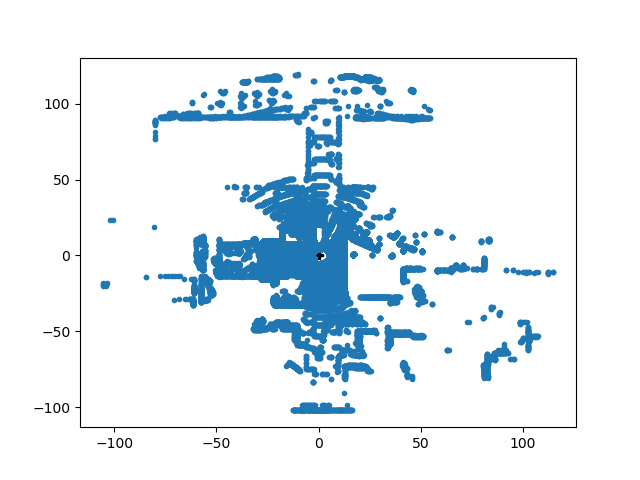

<IPython.core.display.Javascript object>


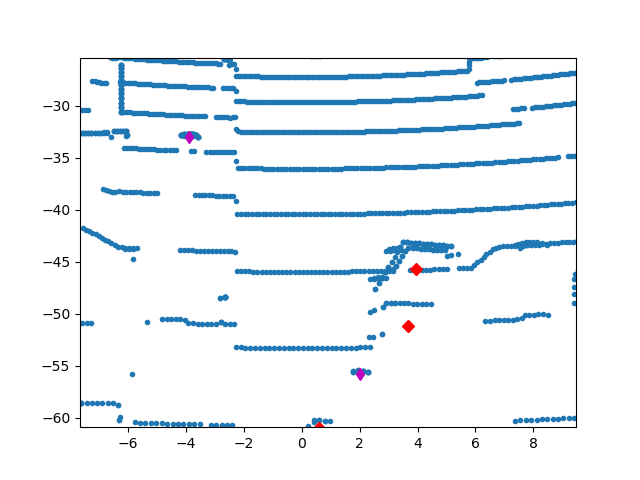

Black +: Lidar center | Red diamond: Vehicle | Magenta diamond: Pedestrian


,extent_x,extent_y,extent_z,id,location_x,location_y,location_z,max_extent,min_extent,type,yaw
2,2.496583,0.970844,0.789848,3093110383,1.807670,70.499268,38.091808,2.496583,0.970844,vehicle,-90.016388
3,1.934053,0.953285,0.940000,3652578218,117.642197,-1.958214,38.115887,1.934053,0.953285,vehicle,-179.790985
4,1.834424,0.832002,0.761607,762341386,157.625763,129.737473,38.099670,1.834424,0.832002,vehicle,179.995956
6,2.259523,0.865187,1.013224,2723768229,67.728035,2.008610,38.097881,2.259523,0.865187,vehicle,0.047667
9,1.101248,0.687601,0.673248,3953845314,-2.390990,129.596008,38.112312,1.101248,0.687601,vehicle,90.029938
12,2.260000,0.960000,0.943565,1014665532,92.566170,48.500095,38.120693,2.260000,0.960000,vehicle,-102.008011
13,2.269167,0.935048,0.768681,615653247,1.888993,97.556671,38.146542,2.269167,0.935048,vehicle,-90.027550
16,0.667911,0.383117,0.371510,1885076882,89.233276,33.195530,38.070789,0.667911,0.383117,vehicle,80.426315
18,0.667911,0.383117,0.371510,1479854161,131.936020,2.295357,38.006737,0.667911,0.383117,vehicle,0.434324
20,1.859311,0.837539,0.767747,3567853064,121.839005,59.439896,38.099976,1.859311,0.837539,vehicle,-0.069855


In [11]:
# For example
sample_row = df_gt.iloc[np.random.choice(df_gt.shape[0])]
sample_step_idx = int(sample_row['step'])
sample_json_file = str(sample_step_idx) + ".json"
sample_ply = str(sample_step_idx) + ".ply"

json_file_path = os.path.join(NONPLAYERS_PATH, sample_json_file)

with open(json_file_path, "r") as json_file_data:
    json_file_str = json_file_data.read()
    
dynamic_non_player_type_list = ["vehicle", "pedestrian"]

non_player_str_list = re.split("non_player_agents", json_file_str)
non_player_str_list

dynamic_str_list = [non_player_str for non_player_str in non_player_str_list[1:]\
                                    for non_player_type in dynamic_non_player_type_list\
                                      if non_player_type in non_player_str]

dataframe_list = []
for dynamic_str in dynamic_str_list:
    clean_str_list = [some_str for some_str in re.split("[:{}\n ]", dynamic_str) if some_str]
    try:
        dataframe_list.append(parse_clean_list(clean_str_list))
    except:
        pass

df_nonplayer = pd.DataFrame(dataframe_list)

lidar_center = np.array([sample_row['location_x'], sample_row['location_y']])
df_feasible_nonplayer = df_nonplayer[np.array([np.linalg.norm(lidar_center - np.array([row['location_x'], row['location_y']])) < (LIDAR_RANGE + row['min_extent']) \
                                         for idx, row in df_nonplayer.iterrows()])]



this_pcd = o3d.read_point_cloud(os.path.join(DYNAMIC_PATH, sub_folder, PCD_FOLDER, sample_ply))
that_pcd = copy.deepcopy(this_pcd)
# transform_mat = pose2matrix([0, 0, 0], [sample_row['rotation_roll'],sample_row['rotation_pitch'],sample_row['rotation_yaw']])
transform_mat = pose2matrix([0,0,0], [0,0,sample_row['rotation_yaw']])
that_pcd.transform(transform_mat)
that_pcd_arr = np.asarray(that_pcd.points)
# that_pcd_arr = np.array([np.array([x,y,z]) for x,y,z in that_pcd_arr if z < 2])



plt.figure()
plt.plot(sample_row['location_x']-sample_row['location_x'], sample_row['location_y']-sample_row['location_y'], 'P', c='k')
plt.plot(-that_pcd_arr[:,1],that_pcd_arr[:,0], '.')

plt.figure()
plt.plot(sample_row['location_x']-sample_row['location_x'], sample_row['location_y']-sample_row['location_y'], 'P', c='k')
plt.plot(-that_pcd_arr[:,1],that_pcd_arr[:,0], '.')
plt.plot(df_feasible_nonplayer[df_feasible_nonplayer['type']=='vehicle']['location_x']-sample_row['location_x'], df_feasible_nonplayer[df_feasible_nonplayer['type']=='vehicle']['location_y']-sample_row['location_y'], 'D', c='r')
plt.plot(df_feasible_nonplayer[df_feasible_nonplayer['type']=='pedestrian']['location_x']-sample_row['location_x'], df_feasible_nonplayer[df_feasible_nonplayer['type']=='pedestrian']['location_y']-sample_row['location_y'], 'd', c='m')

print("Black +: Lidar center | Red diamond: Vehicle | Magenta diamond: Pedestrian")
df_feasible_nonplayer